In [1]:
from imports import *
import networkx as nx
np.seterr(all='ignore')
import warnings

In [2]:
def draw_node(df,idx_type):
    
    #Author : BK 7/2020
    # Input df and idx as returned by get_hubs()
    # Output is a plot of the hubs
    
    
    G = nx.DiGraph()
    
    cm = plt.get_cmap('gist_rainbow')
    for i,node in enumerate(np.unique([df['pre_syn'].values,df['post_syn'].values])):
        if idx_type[i,3] == 1:
            G.add_node(node,color = cm(i/len(df)),id = node,Type = 'Pyr')
        elif idx_type[i,3] == 2:
            G.add_node(node,color = cm(i/len(df)),id = node,Type = 'Int')
        else:
            G.add_node(node,color = cm(i/len(df)),id = node,Type = 'Unknown')
#     for i,node in enumerate(np.unique([df['pre_syn'].values,df['post_syn'].values])):
#         G.add_node(node,color = colors[i])
    
    
    
    pyr_nodes = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Pyr']
    int_nodes = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Int']
    other_nodes = list(set(G.nodes()) - set(pyr_nodes) - set(int_nodes))
    
#     print(G.nodes())
#     print(pyr_nodes)
#     print(int_nodes)
#     print(other_nodes)

#  Print to check data
    for edge in zip(df['pre_syn'],df['post_syn']):
        syn_type = df['value'][(df['pre_syn'] == edge[0]) & (df['post_syn'] == edge[1])].values[0]
        if syn_type == 'exc':
            color = 'Red'
        elif syn_type == 'inh':
            color = 'Blue'
        G.add_edge(*edge,color = color)   

    node_colors = nx.get_node_attributes(G,'color')
    edge_colors = nx.get_edge_attributes(G, 'color')
    node_shapes = nx.get_node_attributes(G,'shape')


    pos = nx.spring_layout(G,k = 1)
    
    
    nx.draw_networkx_nodes(G,pos,
                           nodelist=pyr_nodes,
                           node_size = 500,
                           node_color = list([node_colors[i] for i in pyr_nodes]),
                           node_shape = '^')
    nx.draw_networkx_nodes(G,pos,
                           nodelist=int_nodes,
                           node_color = list([node_colors[i] for i in int_nodes]),
                           node_size = 500,
                           node_shape = 'o')
    nx.draw_networkx_nodes(G,pos,
                           nodelist=other_nodes,
                           node_color = list([node_colors[i] for i in int_nodes]),
                           node_size = 500,
                           node_shape = 'd')
    nx.draw(G,
            pos,
            with_labels = True,
            nodelist = [],
            connectionstyle='arc3, rad = 0.3', 
            edge_list = G.edges(),
            edge_color = edge_colors.values(),
            alpha = 0.8,
            width=2.0, 
            edge_cmap=plt.cm.Set2)
    

def get_activity():
    
    # Check for set_current_session 
    try: bk.load.session 
    except NameError: bk.load.session = None
        
    activity = scipy.io.loadmat('Billel/Transitions/NREM_REM_ALL.mat')['binned']['activity'][0][0]
    metadata = scipy.io.loadmat('Billel/Transitions/NREM_REM_ALL.mat')['binned']['metadata'][0][0]
    
    return activity,metadata



# def get_transition_events(states,state1,state2):
#     states_ = np.empty((0,2))
#     transition_events = np.array([])
#     for s1 in states[state1].as_units('s').iloc:
#         for s2 in states[state2].as_units('s').iloc:
#             if ((s1.end+2)>s2.start) and ((s1.end+2)<s2.end) and (s2.end-s2.start)>50:
#                 transition_events = np.append(transition_events,s1.end)
#                 states_ = np.vstack((states_,[s1.start,s2.end]))

#     transition_events = nts.Tsd(transition_events,time_units='s')
#     states_ = nts.IntervalSet(states_[:,0],states_[:,1],time_units = 's')
#     return states_,transition_events
    
def draw_hubs(df,idx,hubs,activity,metadata,plot = True):
    # Author : BK 12/08/20
    # Input : df,idx,hubs as given by get_hubs(session) and activity,metadata given by get_activity
    # Output : it's a plot
    
    cm = plt.get_cmap('gist_rainbow')
    
    for hub in hubs:
        df_hub = df[(df['pre_syn'] == hub) | (df['post_syn'] == hub)]
#         df_hub = df
        repeat = df_hub.pivot_table(index=['pre_syn'],aggfunc='size')
        center = np.argmax(repeat)
        center = repeat.index[center]
#         print(str(center)+' Should be the center of graph')

        l = np.unique([df_hub['pre_syn'].values,df_hub['post_syn'].values])
        idx_type = idx[[x in l for x in idx[:,2]]]

        
        if plot:
            plt.figure()
            plt.suptitle(bk.load.session)
            plt.subplot(1,2,1)
            for c,i in enumerate(np.unique([df_hub['pre_syn'].values,df_hub['post_syn'].values])):
                n_mask = metadata[:,4] == i
                norm = np.mean(activity[20:30,n_mask,:])
                plt.plot((np.mean(activity[:,n_mask,:],2)/1),color = cm(c/len(df_hub)))
        #         plt.plot((v[:,17]),color = cm(c/len(df_hub)))

            plt.axvspan(30,41, facecolor='darkorange', alpha=0.5)
            plt.title('Activity')
            plt.ylabel('FR')
            plt.xlabel('Time Normalized')
            plt.subplot(1,2,2)
            plt.title(str(idx[idx[:,2] == center,0:2]) +'#' + str(center)+ ' cell hub')
            plt.show()
            draw_node(df_hub,idx_type)
        
def flatten_activity(activity):  
    # Because of how reshape works we have to swap axes before reshaping. We need to have the slowest index in the end so it can be reshape in "C" Order.
    # This function take activity matrix as Time,Neurons,Events and transforms it into Time,Events,Neurones
    print(activity.T.swapaxes(1,2).shape)
    flat_activity = activity.T.swapaxes(1,2).reshape(-1,activity.shape[1])
    return flat_activity
        

In [3]:
def write_monosyn(base_folder, local_path):
    bk.load.current_session_linux(
        base_folder='/mnt/electrophy/Gabrielle/GG-Dataset/', local_path=local_path)
    MonoSynConvClick = scipy.io.loadmat(
        bk.load.session + '-MonoSynConvClick.mat')
    neurons, metadata = bk.load.spikes()
    syn_inh = np.column_stack((MonoSynConvClick['FinalInhMonoSynID'][:, 0]-1,
                               MonoSynConvClick['FinalInhMonoSyn'][:, 0:2],
                               MonoSynConvClick['FinalInhMonoSynID'][:, 1]-1,
                               MonoSynConvClick['FinalInhMonoSyn'][:, 2:4]))
    df_inh = pd.DataFrame(syn_inh, columns=[
                          'pre_index', 'pre_shank', 'pre_id', 'post_index', 'post_shank', 'post_id'])
    df_inh['pre_type'] = 'Int'
    df_inh['connexion_type'] = 'inh'
    syn_exc = np.column_stack((MonoSynConvClick['FinalExcMonoSynID'][:, 0]-1,
                               MonoSynConvClick['FinalExcMonoSyn'][:, 0:2],
                               MonoSynConvClick['FinalExcMonoSynID'][:, 1]-1,
                               MonoSynConvClick['FinalExcMonoSyn'][:, 2:4]))
    df_exc = pd.DataFrame(syn_exc, columns=[
                          'pre_index', 'pre_shank', 'pre_id', 'post_index', 'post_shank', 'post_id'])
    df_exc['pre_type'] = 'Pyr'
    df_exc['connexion_type'] = 'exc'

    df = pd.concat((df_exc, df_inh))
    df['post_type'] = metadata['Type'].iloc[df['post_index']].values
    df = df[['pre_index', 'pre_shank', 'pre_id','pre_type', 'post_index', 'post_shank', 'post_id','post_type','connexion_type']]

    bk.load.current_session_linux(byrat=bk.load.rat, byday=bk.load.day)
    os.makedirs('Analysis/MonoSyn', exist_ok=True)
    df.to_csv('Analysis/MonoSyn/mono_syn.csv', index=False)
    return True

# batch,meta = bk.load.batch(write_monosyn,verbose=False)


In [4]:
def get_hubs(stru = None, metadata = None):
    monosyn = pd.read_csv('Analysis/MonoSyn/mono_syn.csv')

    hubs = []
    for i in monosyn.pre_index.unique():
        hub = monosyn[(monosyn.pre_index == i) & (monosyn.connexion_type == 'inh')]
        if len(hub)>1: hubs.append(hub)

    if stru is not None:
        keep = [] 
        for i,hub in enumerate(hubs):
            if metadata.Region[hub.pre_index.unique()].values == stru: keep.append(i)
        hubs = [hubs[i] for i in keep]
    return hubs

In [5]:
def main(base_folder,local_path):
   bk.load.current_session_linux(base_folder,local_path)
   neurons, metadata = bk.load.spikes()
   states = bk.load.states(True)
   for s in ['wake', 'drowsy']:
      states.pop(s)
   activity = bk.compute.binSpikes(neurons,binSize=5,as_Tsd=True)
   monosyn = pd.read_csv('Analysis/MonoSyn/mono_syn.csv')

   hubs = []
   for i in monosyn.pre_index.unique():
      hub = monosyn[(monosyn.pre_index == i) & (monosyn.connexion_type == 'inh')]
      if len(hub)>1: hubs.append(hub)

   eibs = []
   center = []
   outer = []
   for i,hub in enumerate(hubs):
      if metadata.Region[hub.pre_index.unique()].values == 'BLA':
         center.append(hub.pre_index.unique())
         outer.append(hub[hub.post_type == 'Pyr'].post_index.unique())
         
         inh = activity[hub.pre_index.unique()]
         exc = activity[hub[hub.post_type == 'Pyr'].post_index.unique()]
         eib = np.mean(exc.values,1)/(np.mean(exc.values,1) + np.mean(inh.values,1))
         eibs.append(nts.Tsd(activity.times(),zscore(eib,nan_policy='omit')))

   df = pd.DataFrame()
   for state,inter in states.items() :
      average_state = []
      for eib in eibs:
         average_state.append(np.nanmean(eib.restrict(inter)))
      df[state] = average_state
   df['rat'] = bk.load.rat
   df['center'] = center
   df['outer'] = outer
   os.makedirs('Analysis/Hubs',exist_ok=True)
   df.to_csv('Analysis/Hubs/hubs_eib.csv')
   return df

In [6]:
# batch, metadata = bk.load.batch(main)

In [7]:
df = pd.concat(batch)
df = df[['NREM','REM','WAKE_HOMECAGE','rat']]
df = df.reset_index()
print(scipy.stats.friedmanchisquare(df['NREM'],df['REM'],df['WAKE_HOMECAGE']))
pairs = list(itertools.combinations(['NREM','REM','WAKE_HOMECAGE'],2))

NameError: name 'batch' is not defined

In [8]:
df_melt = df.melt(value_name='EIB', value_vars=[
                  'NREM', 'REM', 'WAKE_HOMECAGE'], var_name='State', id_vars='rat')

fig, ax = plt.subplots(1, 1, dpi=180, figsize=(4, 8))
plotting_params = {'data': df_melt,
                   'x':'State',
                   'y':'EIB',
                   'order': ['NREM', 'REM', 'WAKE_HOMECAGE'],
                #    'hue':'State',
                   'ax': ax}
sns.boxenplot(**plotting_params)
sns.stripplot(**plotting_params, color='grey', size=3, alpha=0.8)
annotator = Annotator(pairs=pairs, **plotting_params)
annotator.configure(test="Wilcoxon",
                    comparisons_correction='Bonferroni').apply_and_annotate()



values = np.array(df[['NREM','REM','WAKE_HOMECAGE']]).T
n_values = values.shape[1]

x = np.array([[0]*n_values,[1]*n_values,[2]*n_values])
plt.plot(x,values,'grey',linewidth =0.5)

NameError: name 'df' is not defined

In [9]:
def compute_sync(neurons,center_idx,outer_idx,start=0, stop=None, binSize=0.025):
    t1,center_act = bk.compute.binSpikes(neurons[center_idx],start = start, stop = stop)
    t2,outer_act = bk.compute.binSpikes(neurons[outer_idx],start = start, stop = stop)

    c = np.corrcoef(center_act,outer_act)
    np.fill_diagonal(c,np.nan)
    with warnings.catch_warnings():

        warnings.simplefilter("ignore", category=RuntimeWarning)
        return np.nanmean(c[0,:])
    

def pop_one_neuron_moving_average(neurons,center_idx,outer_idx,start=0, stop=None, binSize=0.025, window_size=10, step=1):
    if stop is None: 
        stop = np.max([n.times('s')[-1] for n in neurons])
    
    bins = np.arange(start,stop,step)
    sync = []
    t = []
    for s,e in tqdm(zip(bins,bins+window_size),total = len(bins)):
        if e>stop: continue 
        sync.append(compute_sync(neurons,center_idx,outer_idx,start = s,stop = e))
        t.append((s+e)/2)

    sync = nts.Tsd(np.array(t),np.array(sync),time_units='s')
    return sync

In [10]:
def compute_sync(center_act,outer_act):

    c = np.corrcoef(center_act.values.T,outer_act.values.T)
    np.fill_diagonal(c,np.nan)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        return np.nanmean(c[0,:])

def pop_one_neuron_moving_average(neurons,center_idx,outer_idx,start=0, stop=None, binSize=0.025, window_size=10, step=1):
    if stop is None: 
        stop = np.max([n.times('s')[-1] for n in neurons])
    
    t_,center_act = bk.compute.binSpikes(neurons[center_idx],start = start, stop = stop)
    t,outer_act = bk.compute.binSpikes(neurons[outer_idx],start = start, stop = stop)
    
    bins = np.arange(start,stop,step)
    sync = []
    t = []
    for s,e in tqdm(zip(bins,bins+window_size),total = len(bins)):
        if e>stop: continue 
        sync.append(compute_sync(center_act[:,(s<t_) & (t_<e)],outer_act[:,(s<t_) & (t_<e)]))
        t.append((s+e)/2)

    sync = nts.Tsd(np.array(t),np.array(sync),time_units='s')
    return sync

def main(base_folder,local_path):


    bk.load.current_session_linux(base_folder,local_path)
    if os.path.exists('Analysis/Hubs/hubs_sync.csv'):
        return pd.read_csv('Analysis/Hubs/hubs_sync.csv')
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)
    for s in ['wake', 'drowsy']:
        states.pop(s)
    hubs = get_hubs('BLA',metadata)
    syncs = []
    for hub in tqdm(hubs,total = len(hubs)):
        syncs.append(pop_one_neuron_moving_average(neurons,hub.pre_index.unique(),hub.post_index,binSize=0.1))
    df = pd.DataFrame()
    for state,inter in states.items() :
        average_state = []
        for sync in syncs:
            average_state.append(np.nanmean(sync.restrict(inter)))
        df[state] = average_state
    df['rat'] = bk.load.rat
    df['day'] = bk.load.day
    
    
    center = [hub.pre_index.unique() for hub in hubs]
    outer = [hub.post_index.unique() for hub in hubs]
    df['center'] = center
    df['outer'] = outer
    os.makedirs('Analysis/Hubs',exist_ok=True)
    df.to_csv('Analysis/Hubs/hubs_sync.csv',index= False)

    return df


In [11]:
def pop_one_neuron_state_sync(neurons,center_idx,outer_idx,states, binSize=0.025):
    stop = np.max([n.times('s')[-1] for n in neurons])
    center_act = bk.compute.binSpikes(neurons[center_idx],start = 0, stop = stop,as_Tsd=True)
    outer_act = bk.compute.binSpikes(neurons[outer_idx],start = 0, stop = stop,as_Tsd=True)

    syncs = {}
    for state in states:
        syncs[state] = compute_sync(center_act.restrict(states[state]),outer_act.restrict(states[state]))
    return syncs

def main(base_folder,local_path):
    bk.load.current_session_linux(base_folder,local_path)
    if os.path.exists('Analysis/Hubs/hubs_sync.csv'):
        return pd.read_csv('Analysis/Hubs/hubs_sync.csv')
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)
    for s in ['wake', 'drowsy']:
        states.pop(s)
    hubs = get_hubs('BLA',metadata)
    syncs = []
    for hub in tqdm(hubs,total = len(hubs)):
        syncs.append(pop_one_neuron_state_sync(neurons,hub.pre_index.unique(),hub.post_index,states,binSize=0.1))
    
    df = pd.DataFrame(syncs)

    df['rat'] = bk.load.rat
    df['day'] = bk.load.day
    
    
    center = [hub.pre_index.unique() for hub in hubs]
    outer = [hub.post_index.unique() for hub in hubs]
    df['center'] = center
    df['outer'] = outer

    df = df[['rat','day','NREM','REM','WAKE_HOMECAGE','center','outer']]
    os.makedirs('Analysis/Hubs',exist_ok=True)
    df.to_csv('Analysis/Hubs/hubs_sync.csv',index= False)
    return syncs

In [12]:
batch, metadata = bk.load.batch(main)

100%|██████████| 61/61 [00:22<00:00,  2.67it/s]

['Rat08-20130708', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 22.896705865859985
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140620', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', '

In [16]:
df = pd.concat(batch)
df = df[['NREM','REM','WAKE_HOMECAGE','rat']]
df = df.reset_index()
print(scipy.stats.friedmanchisquare(df['NREM'],df['REM'],df['WAKE_HOMECAGE']))
pairs = list(itertools.combinations(['NREM','REM','WAKE_HOMECAGE'],2))

FriedmanchisquareResult(statistic=119.68707482993182, pvalue=1.023957480575041e-26)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NREM vs. REM: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.426e-20 Stat=6.680e+02
REM vs. WAKE_HOMECAGE: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.985e-01 Stat=4.723e+03
NREM vs. WAKE_HOMECAGE: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.613e-17 Stat=9.970e+02


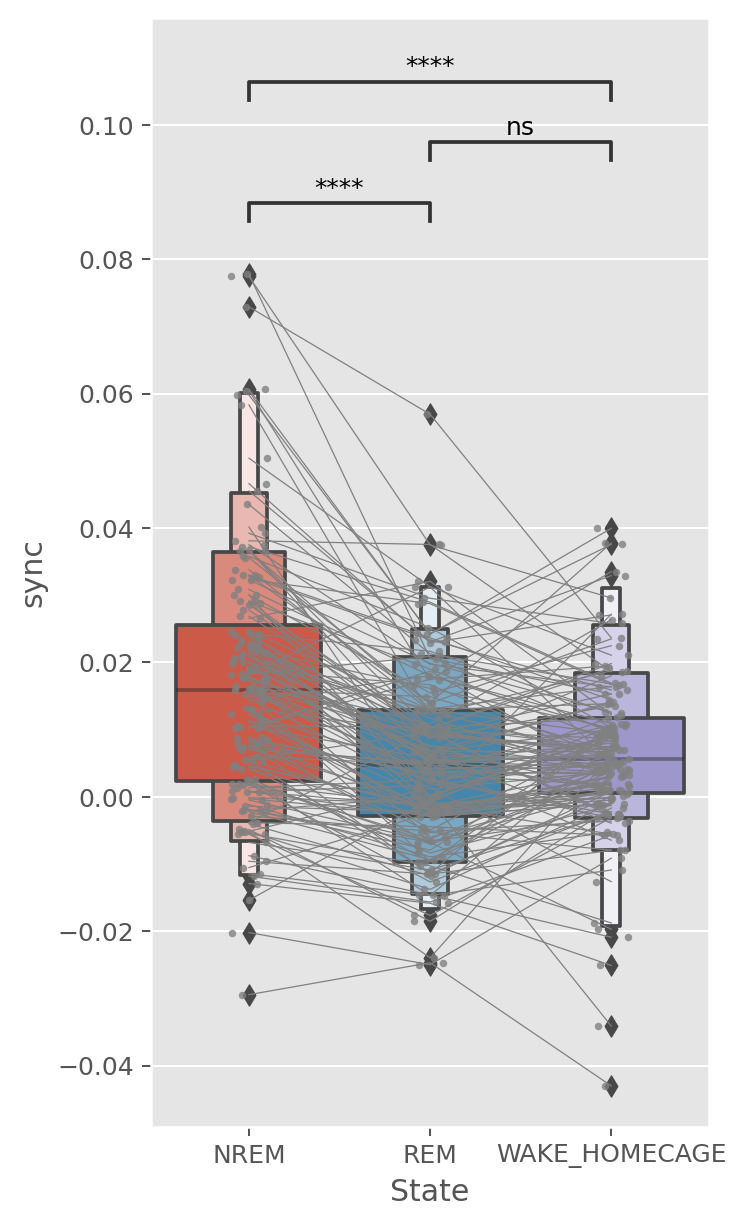

In [18]:
df_melt = df.melt(value_name='sync', value_vars=[
                  'NREM', 'REM', 'WAKE_HOMECAGE'], var_name='State', id_vars='rat')

fig, ax = plt.subplots(1, 1, dpi=180, figsize=(4, 8))
plotting_params = {'data': df_melt,
                   'x':'State',
                   'y':'sync',
                   'order': ['NREM', 'REM', 'WAKE_HOMECAGE'],
                #    'hue':'State',
                   'ax': ax}
sns.boxenplot(**plotting_params)
sns.stripplot(**plotting_params, color='grey', size=3, alpha=0.8)
annotator = Annotator(pairs=pairs, **plotting_params)
annotator.configure(test="Wilcoxon",
                    comparisons_correction='Bonferroni').apply_and_annotate()



values = np.array(df[['NREM','REM','WAKE_HOMECAGE']]).T
n_values = values.shape[1]

x = np.array([[0]*n_values,[1]*n_values,[2]*n_values])
plt.plot(x,values,'grey',linewidth =0.5)
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/sync_hubs_pyr_int.svg')

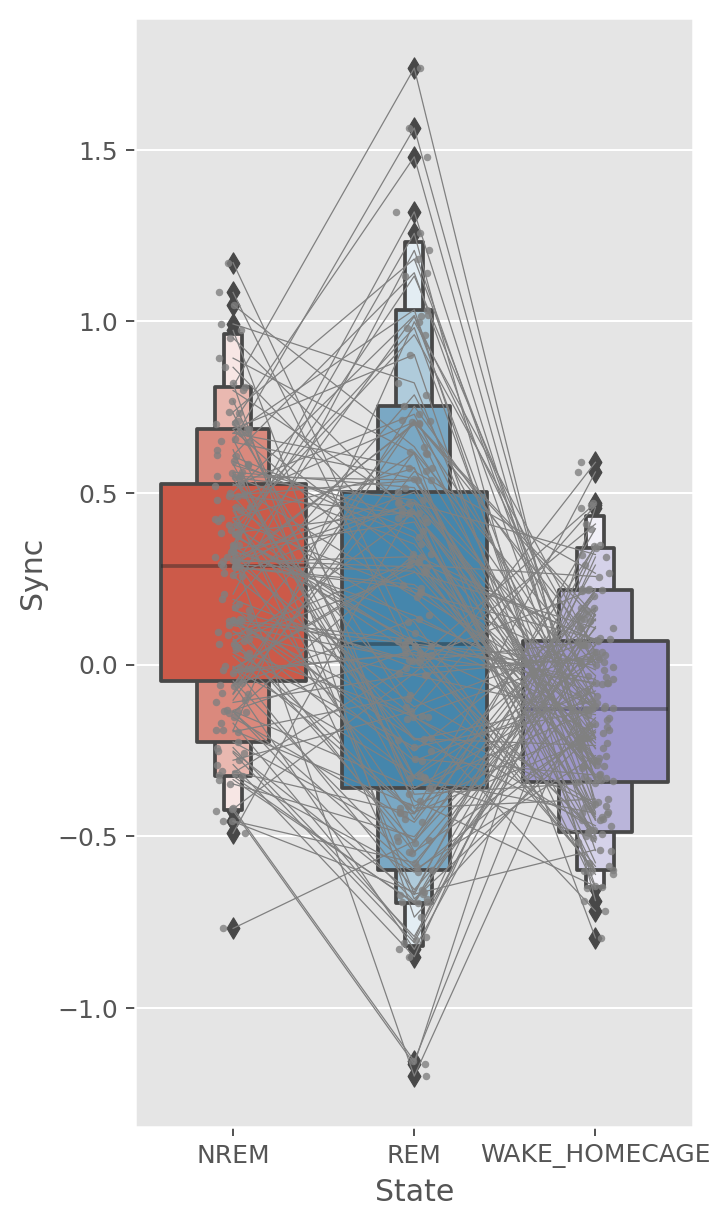

In [33]:
df_melt = df.melt(value_name='Sync', value_vars=[
                  'NREM', 'REM', 'WAKE_HOMECAGE'], var_name='State', id_vars='rat')

fig, ax = plt.subplots(1, 1, dpi=180, figsize=(4, 8))
plotting_params = {'data': df_melt,
                   'x':'State',
                   'y':'Sync',
                   'order': ['NREM', 'REM', 'WAKE_HOMECAGE'],
                #    'hue':'State',
                   'ax': ax}
sns.boxenplot(**plotting_params)
sns.stripplot(**plotting_params, color='grey', size=3, alpha=0.8)
# annotator = Annotator(pairs=pairs, **plotting_params)
# annotator.configure(test="Wilcoxon",
#                     comparisons_correction='Bonferroni').apply_and_annotate()



values = np.array(df[['NREM','REM','WAKE_HOMECAGE']]).T
n_values = values.shape[1]

x = np.array([[0]*n_values,[1]*n_values,[2]*n_values])
plt.plot(x,values,'grey',linewidth =0.5)

In [ ]:
%matplotlib qt
fig,ax =plt.subplots(dpi = 180)
ax.plot(sync.as_units('s'))
bk.plot.intervals(states['REM'],ax = ax)

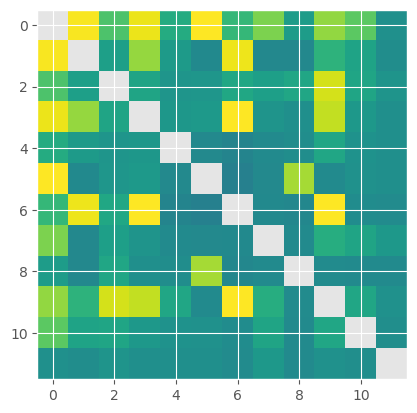

In [ ]:
plt.imshow(c)
plt.clim(-0.04,0.04)

In [140]:
c[0,:]

array([1.00000000e+00, 3.92056513e-02, 1.76709240e-02, 3.77264842e-02,
       9.34061484e-03, 4.32797889e-02, 1.31796611e-02, 2.42641945e-02,
       4.20631338e-03, 2.69672576e-02, 1.98878169e-02, 1.50332116e-04])

In [141]:
c[:,0]

array([1.00000000e+00, 3.92056513e-02, 1.76709240e-02, 3.77264842e-02,
       9.34061484e-03, 4.32797889e-02, 1.31796611e-02, 2.42641945e-02,
       4.20631338e-03, 2.69672576e-02, 1.98878169e-02, 1.50332116e-04])

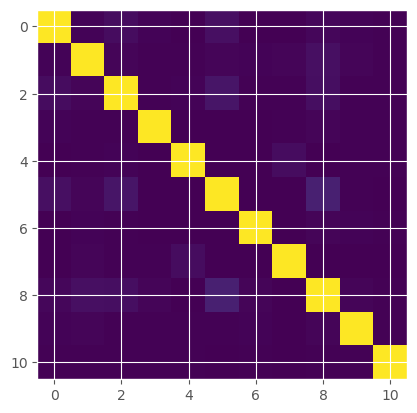

In [129]:
c = np.corrcoef(outer,rowvar=True)
plt.imshow(c)

In [96]:
a = 

In [91]:
neurons[83].as_units('s')

Time (s)
0.09315       NaN
0.47855       NaN
0.48880       NaN
0.49045       NaN
0.92995       NaN
               ..
22679.70890   NaN
22679.80420   NaN
22679.82930   NaN
22679.87230   NaN
22679.90850   NaN
Length: 244700, dtype: float64